## Imports

In [2]:
import pandas as pd

In [3]:
!git clone https://github.com/mwolfe03/ChemRiskPredict.git
%cd ChemRiskPredict

Cloning into 'ChemRiskPredict'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 103 (delta 59), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (103/103), 292.07 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/ChemRiskPredict


In [4]:
!pip install -U git+https://github.com/mwolfe03/ChemRiskPredict.git
%cd ChemRiskPredict

  Cloning https://github.com/mwolfe03/ChemRiskPredict.git to /tmp/pip-req-build-6cs7124c
  Running command git clone --filter=blob:none --quiet https://github.com/mwolfe03/ChemRiskPredict.git /tmp/pip-req-build-6cs7124c
  Resolved https://github.com/mwolfe03/ChemRiskPredict.git to commit 6bcf80d57b911bc92060f41b4f08ec5f019345ec
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 18.7 MB/s eta 0:00:00
  Created wheel for ChemRiskPredict: filename=ChemRiskPredict-1.0.0-py3-none-any.whl size=1269 sha256=d2bdfb13f6217fe6943ae835751dc6dddc75d79e4390a60d28b7b988ec15453a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9gcar3z3/wheels/de/cb/45/173ab6797cb4582d108c6016a3a7cd497ee08ef29081d99504
Successfully built ChemRiskPredict
[Errno 2] No such file or directory: 'ChemRiskPredict'
/content/ChemRiskPredict


In [5]:
import ChemRiskPredict as chemrp

## Explanation of how potential hazards are determined
hazard prediction is done using chemrp.determine_potential_hazards_from_dataframe(). This function takes in a string representation of the SMILES structure.

In [23]:
SMILES_string = "CC1CCC2(C(C3C(O2)CC4C3(C(=O)CC5C4CCC6C5(CCC(C6)OC(=O)C)C)C)C)OC1"

chemrp.determine_potential_hazards_from_dataframe(canonical_smiles=SMILES_string,
                                                  # Default parameters
                                                  main_df=chemrp.default_data_df,
                                                  min_probability=.3,
                                                  num_neighbors=5,
                                                  algorithm="auto",
                                                  metric="cosine")

,AcuteToxic,Flammable,HealthHazard,Corrosive,EnvironmentalHazard
0,0,0,1,0,0


chemrp.determine_potential_hazards_from_dataframe() takes in a pd.DataFrame that was created via one of chemrp's DataFrame creation methods, and a Canonical SMILES string. The pd.DataFrame must have been made by chemrp otherwise it will not be in the proper format and errors will raise.

What this function does is:

1. Parse the Canonical SMILES string to create the different subgroups and subgroup combinations. Then turn this into a dataframe with columns representing the subgroup hashes. This **new** **dataframe** only contains the info for this string.
2. Clone the **input** **dataframe** so that the clone can be mutated.
3. Clean the **cloned dataframe** so that only hash columns remain
4. Remove all columns from the **new dataframe** that are not present in the cleaned dataframe.
5. Remove all columns from the **cleaned datafram**e that have a sum of less than 1 and are not present in the **new dataframe**. This done to remove data that is less helpful to us in finding the input molecules nearest neighbors.
6. Use sklearn.neighbors's NearestNeighbors to create a model out of the cloned, cleaned dataframe, and input the new dataframe made from the SMILES to determine the nearest neighbors
7. The neighbors' hazards are then collecting by indexing into the original input dataframe.
8. A hazard probability is then determined by dividing the number of neighbors with said hazard by the number of neighbors
9. If this probability is greater than or equal to the min_probability (another optional input that is .3 by default), we predict that the target molecule does have that particular hazard. (steps 7-9 are done for each hazard in unison)
10. Dataframe is created to display which hazards the target molecule has (1) and doesn't have (0)

one call takes between .8 and 1.2 seconds, this needs to be fixed in the future. I plan on looking into doing in a way such that I am not creating this many dataframes.



Premade training and testing datasets are accesible via chemrp.default_data_df and chemrp.default_testing_data_df.

In [24]:
chemrp.default_data_df.head()
# Unamed columns are the result of an issue with the csv. This issue will be fixed over the summer

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Compound ID,IUPAC Name,Canonical SMILES,Hazards,Irritant,HealthHazard,Flammable,...,80913ee232144e6252ecd64ee14cddc3,e50c0e418de1bffe6ebe5cd9d77a1779,0a8a242b3aec4b643a5db5f20023a8dc,6f803c3f75396ccc4f8a852e9748e550,17404efb30fd2d13e83e084865eac2d7,952f01fa7453bcb9541920dbc0a6f575,244c147de5d960d5e46bc43c8fbc7113,b46ac342e982a82087c8d741dcbd0d57,52581e12ab259ea5c4c84bda6dfe6079,6bb7c7c19a8eced0ba1d57c4d13a0d8c
0,183,175,759,6584,methyl acetate,CC(=O)OC,"Flammable, Irritant, Flammable, Irritant, Flam...",1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,253,388,526,5957,"[[(2R,3S,4R,5R)-5-(6-aminopurin-9-yl)-3,4-dihy...",C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,Acute Toxic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,98,132,1530,8956,"(8S,9S,10R,13S,14S,17S)-17-[(1S)-1-hydroxyethy...",CC(C1CCC2C1(CCC3C2CCC4=CC(=O)CCC34C)C)O,"Irritant, Health Hazard",1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,36,369,1487,6119,2-amino-2-methylpropanoic acid,CC(C)(C(=O)O)N,Irritant,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61,0,752,7609,"1,2-dichloro-4-(chloromethyl)benzene",C1=CC(=C(C=C1CCl)Cl)Cl,"Corrosive, Irritant",1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Optimal Model Determination

models/ parameters can be tested by using chemrp.hazard_model_testing(). It takes in a pd.dataframe made by chemrp that will be used for testing, and a second pd.dataframe built by chemrp to be used for building the "model". After this, varius paramaters can be set such as "min_probability" and "num_neighbors".

In [11]:
predictions = chemrp.hazard_model_testing(testing_df=chemrp.default_testing_data_df,
                                                main_df=chemrp.default_data_df,
                                                min_probability=.3,
                                                num_neighbors=5,
                                                algorithm="auto",
                                                metric="cosine")
predictions

,Statistic,AcuteToxic,Flammable,HealthHazard,EnvironmentalHazard,Corrosive
0,Correct Prediction Proportion,0.671875,0.851562,0.632812,0.734375,0.710938
1,False Positive Proportion,0.179688,0.085938,0.242188,0.148438,0.140625
2,False Negative Proportion,0.148438,0.062500,0.125000,0.117188,0.148438


How the code works:
It is important to note that the testing dataframe is filled with molecules of known hazards.

1. For each row in the testing dataframe, the canonical smiles string of that row is put into chemrp.determine_potential_hazards_from_dataframe() along with the training dataframe and the rest of the parameters (num_neighbors, min_probability and so on). What is returned from that function is a table with the predicted hazards
2. Since the data we are testing the model with have known hazards, we can count the number of times chemrp.determine_potential_hazards_from_dataframe() correctly predicts a hazard, predicts a false positive, and predicts a false negative.
3. A dataframe of the Accurate prediction proportions, False positive prediction proportions, and false negative prediction proportions for each hazard is returned.

It is important to note that the "model" is the parameters inputted into chemrp.determine_potential_hazards_from_dataframe()

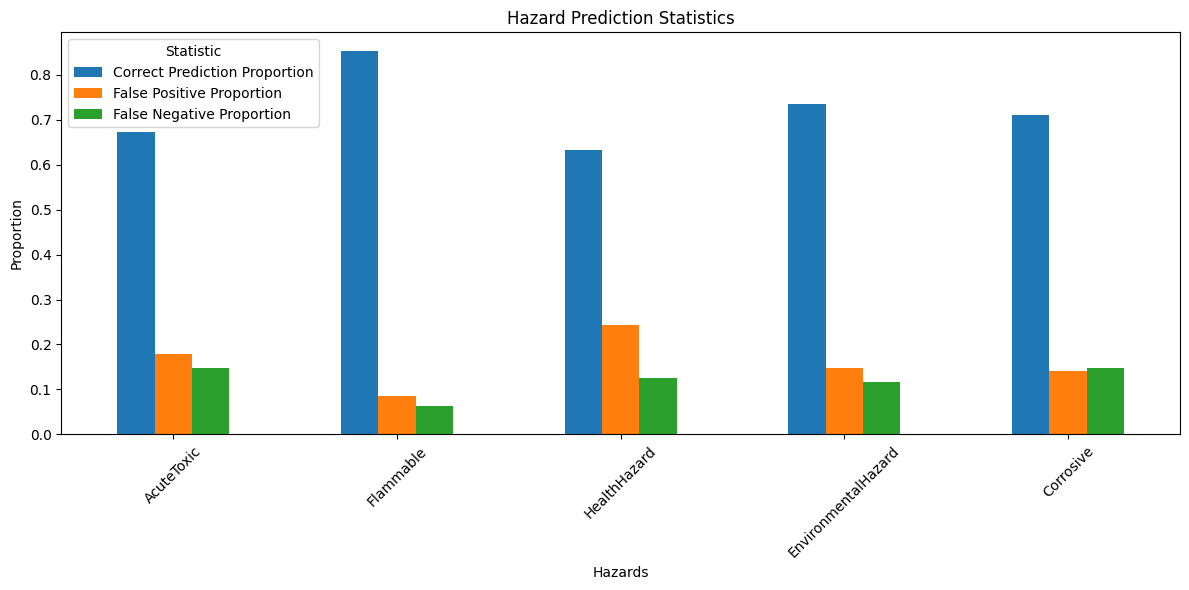

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the index to 'Statistic'
predictions.set_index('Statistic', inplace=True)

# Plot the data
predictions.T.plot(kind='bar', figsize=(12, 6))

# Add title and labels
plt.title('Hazard Prediction Statistics')
plt.xlabel('Hazards')
plt.ylabel('Proportion')
plt.legend(title='Statistic')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### How we determined the optimal model

To determine how "good" a model is, we focus on two metrics, the average correct predictions, and the average false negatives among all hazards. We believe these to be the most important categories as we need our model to be accurate, but we also need a lower false negative probability as we do not want our model to **predict** that something is not not have certain hazard when in reality it does.

Model score = avg Correct probability - avg false negative probability


In [26]:
import numpy as np

In [30]:

score_dict_cosine = {}
for num_neighbors in range(5, 40, 7):
  for min_probability in np.arange(0.3, 1, 0.25):
    prediction_info_1 = chemrp.hazard_model_testing(testing_df=chemrp.default_testing_data_df,
                                                  main_df=chemrp.default_data_df,
                                                  min_probability=min_probability,
                                                  num_neighbors=num_neighbors,
                                                  algorithm="auto",
                                                  metric="cosine")
    num_columns = len(prediction_info_1.columns)

    prediction_info_1_filled = prediction_info_1.apply(pd.to_numeric, errors='coerce')
    # correctness is on row 0
    summed_correctness = prediction_info_1_filled.iloc[0].sum() / num_columns

    # false negatives are on row 2
    summed_false_negative = prediction_info_1_filled.iloc[2].sum() / num_columns

    score = summed_correctness - summed_false_negative
    key = (f"num_neighbors = {num_neighbors}", f"min_probability = {min_probability}")
    score_dict_cosine[(num_neighbors, min_probability)] =  score



In [33]:
score_dict_cosine

{(5, 0.3): 0.49999999999999994,
 (5, 0.55): 0.44401041666666674,
 (5, 0.8): 0.41666666666666663,
 (12, 0.3): 0.47916666666666674,
 (12, 0.55): 0.41666666666666663,
 (12, 0.8): 0.41927083333333337,
 (19, 0.3): 0.47526041666666663,
 (19, 0.55): 0.41927083333333337,
 (19, 0.8): 0.41927083333333337,
 (26, 0.3): 0.46614583333333337,
 (26, 0.55): 0.41927083333333337,
 (26, 0.8): 0.41927083333333337,
 (33, 0.3): 0.44401041666666663,
 (33, 0.55): 0.41927083333333337,
 (33, 0.8): 0.41927083333333337}

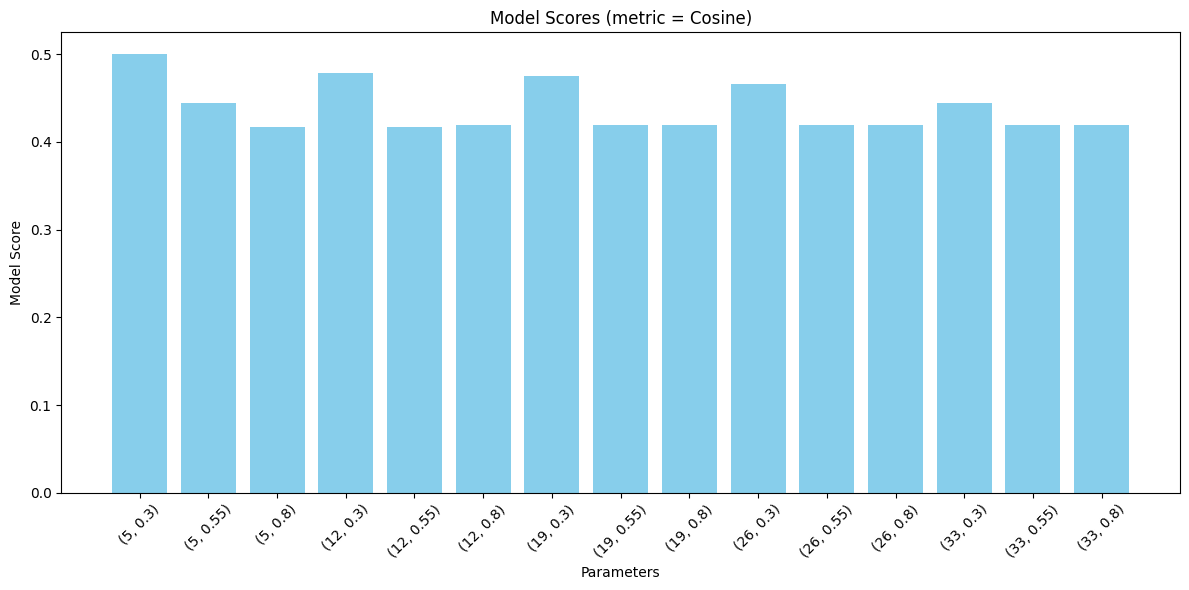

In [39]:
import matplotlib.pyplot as plt



# Create lists for keys and values
keys = list(score_dict_cosine.keys())
values = list(score_dict_cosine.values())
keys_string = []
for key in keys:
  key = str(key)
  keys_string.append(key)

plt.figure(figsize=(12, 6))
plt.bar(keys_string, values, color='skyblue')

# Add title and labels
plt.title('Model Scores (metric = Cosine)')
plt.xlabel('Parameters')
plt.ylabel('Model Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

From this dataset it is apparent that neighbors = 5 and min_prob = .3 are the optimal parameters.

It is also apparent that min_prob = .3 recieves the highest score the most often. From now on, we will only be testing at a probability of .3

In [40]:

score_dict_manhattan = {}
for num_neighbors in range(5, 40, 7):

    prediction_info_1 = chemrp.hazard_model_testing(testing_df=chemrp.default_testing_data_df,
                                                  main_df=chemrp.default_data_df,
                                                  min_probability= .3,
                                                  num_neighbors=num_neighbors,
                                                  algorithm="auto",
                                                  metric="manhattan")
    num_columns = len(prediction_info_1.columns)

    prediction_info_1_filled = prediction_info_1.apply(pd.to_numeric, errors='coerce')
    # correctness is on row 0
    summed_correctness = prediction_info_1_filled.iloc[0].sum() / num_columns

    # false negatives are on row 2
    summed_false_negative = prediction_info_1_filled.iloc[2].sum() / num_columns

    score = summed_correctness - summed_false_negative
    key = (f"num_neighbors = {num_neighbors}", f"min_probability = {min_probability}")
    score_dict_manhattan[(num_neighbors, min_probability)] =  score



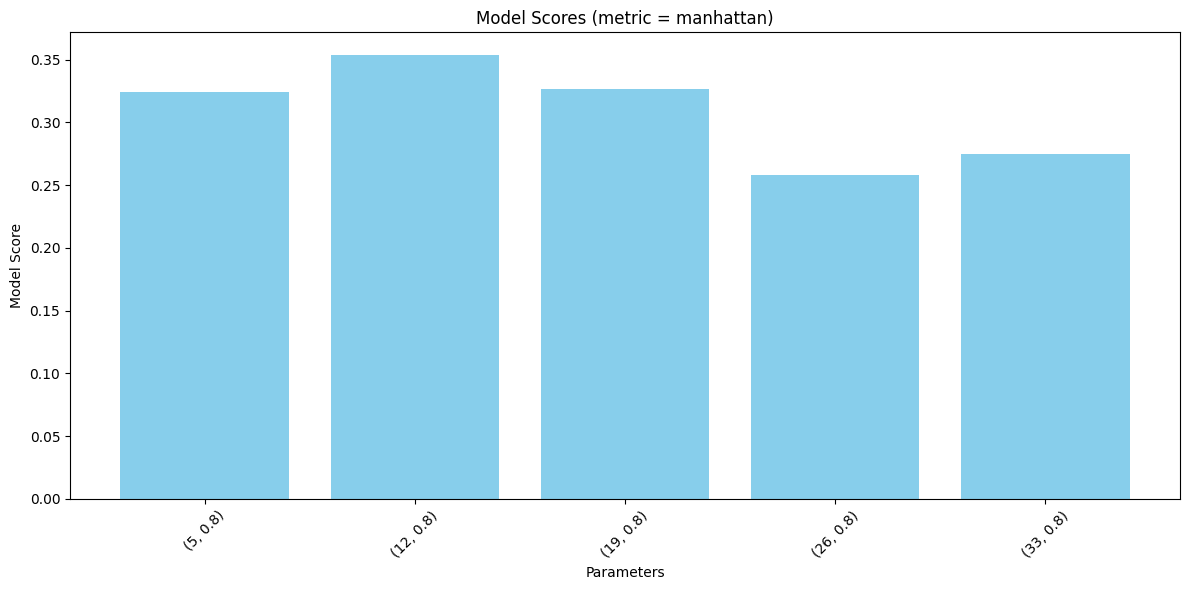

In [41]:
import matplotlib.pyplot as plt



keys = list(score_dict_manhattan.keys())
values = list(score_dict_manhattan.values())

keys_string = []
for key in keys:
  key = str(key)
  keys_string.append(key)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(keys_string, values, color='skyblue')

# Add title and labels
plt.title('Model Scores (metric = manhattan)')
plt.xlabel('Parameters')
plt.ylabel('Model Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

These are lower than the best scores of cosine distance.:

In [42]:

score_dict_euclidean = {}
for num_neighbors in range(5, 40, 7):
  prediction_info_1 = chemrp.hazard_model_testing(testing_df=chemrp.default_testing_data_df,
                                                  main_df=chemrp.default_data_df,
                                                  min_probability=.3,
                                                  num_neighbors=num_neighbors,
                                                  algorithm="auto",
                                                  metric="euclidean")
  num_columns = len(prediction_info_1.columns)

  prediction_info_1_filled = prediction_info_1.apply(pd.to_numeric, errors='coerce')
  # correctness is on row 0
  summed_correctness = prediction_info_1_filled.iloc[0].sum() / num_columns

  # false negatives are on row 2
  summed_false_negative = prediction_info_1_filled.iloc[2].sum() / num_columns

  score = summed_correctness - summed_false_negative
  key = (f"num_neighbors = {num_neighbors}", f"min_probability = {min_probability}")
  score_dict_euclidean[(num_neighbors, min_probability)] =  score



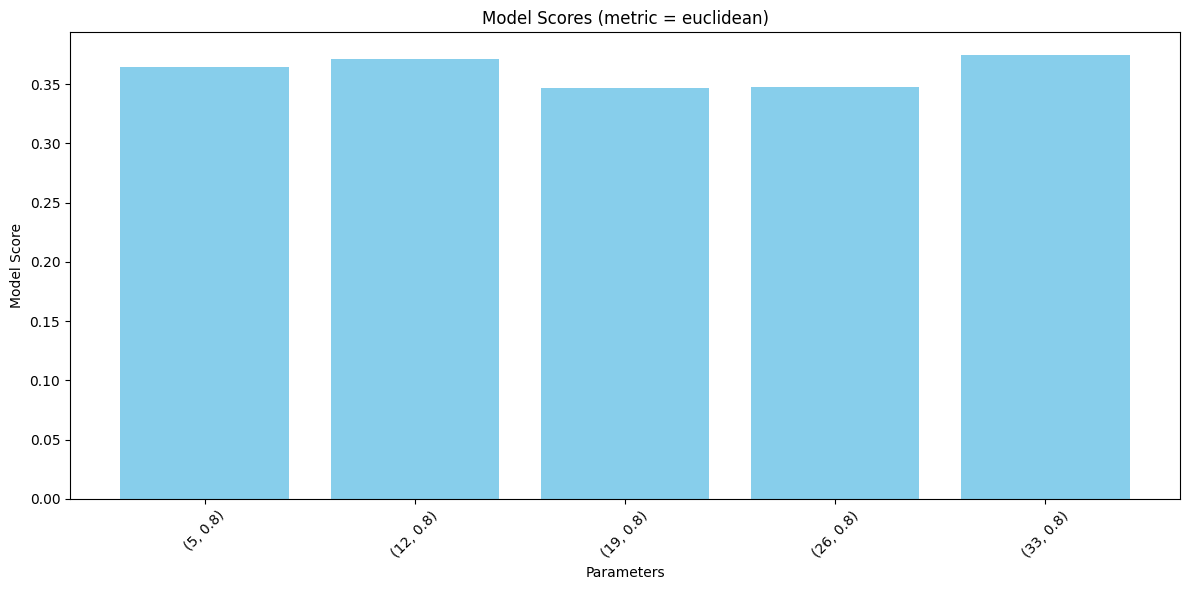

In [43]:
import matplotlib.pyplot as plt



# Create lists for keys and values
keys = list(score_dict_euclidean.keys())
values = list(score_dict_euclidean.values())

keys_string = []
for key in keys:
  key = str(key)
  keys_string.append(key)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(keys_string, values, color='skyblue')

# Add title and labels
plt.title('Model Scores (metric = euclidean)')
plt.xlabel('Parameters')
plt.ylabel('Model Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

These are also lower than the best scores of cosine distance.:

We will now only use metric = "cosine", num_neighbors = 5, and min_probability = 0.3

The only algorithm that works with metric = "cosine" is brute, thus "brute" is the best algorithm to use. "auto" automatically picks brute since it is the only algorithm, so "auto" also works for algorithm.

Thus the optimal paramaters are:
num_neighbors = 5, min_probability = 0.3, metric = "cosine", algorithm = "brute" or "auto". These are the default parameters than are used when running chemrp.determine_potential_hazards_from_dataframe() and chemrp.hazard_model_testing()

It is important to note that we deemed this to be the best model as it worked the best for all hazards, but in certain situations a chemists may want to focus on only one hazard. That is another feature I would like to add to the repository over the summer

## Actual Code in Repository

**Hazard_Prediction_Model.py**

For model testing

In [1]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import Hazard_and_Subgroup_Column_Initialization as data_init

import warnings

# Suppress the specific PerformanceWarning from pandas
# These performance errors will be looked into in the future, but for now it works
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Initializes default_dataframe that comes with the package
try:
    default_data_df = pd.read_csv("default_training_compound_data.csv")
except FileNotFoundError:
    default_data_df = None

# Initializes default_testing_dataframe that comes with the package
try:
    default_testing_data_df = pd.read_csv("default_testing_compound_data.csv")
except FileNotFoundError:
    default_testing_data_df = None



def determine_potential_hazards_from_dataframe(canonical_smiles: str,
                                               main_df: pd.DataFrame=default_data_df,
                                               min_probability: float=.3, num_neighbors: int=5, algorithm: str= "auto",
                                               metric: str="cosine") \
                                               -> pd.DataFrame:
    """
    Input: canonical_smiles is a str. main_df is the dataframe that will be used to fit the model that predicts the
           most similar compounds. min_probability is a float value between 0 and 1 that determines what proportion of
           nearest neighbors must have a hazard for the model to predict that the input molecule will have said hazard.
           num_neighbors is the number of nearest neighbors the model pulls to determine the potential hazards.
           algorithm is a str that represents the algorithm the model will use.
    Output: pd.DataFrame containing columns for each hazard for the input compound. 1 indicates that the model predicts
            that compound will have said hazard. 0 predicts the opposite.
    """

    main_df_cloned = main_df.copy()

    this_smiles_df = data_init.convert_smiles_to_dataframe(canonical_smiles)

    cleaned_main_df = clean_data_frame(main_df, limit_num_groups=False)

    df_tuple = data_init.fit_dataframes(this_smiles_df, cleaned_main_df)

    this_smiles_finished_df = df_tuple[0]
    finished_main_df = df_tuple[1]

    # convert column names to string so that scikit can read them
    this_smiles_finished_df.columns = this_smiles_finished_df.columns.astype(str)
    finished_main_df.columns = finished_main_df.columns.astype(str)

    nn_model = NearestNeighbors(n_neighbors=num_neighbors, algorithm=algorithm, metric=metric).fit(finished_main_df)
    stuff = nn_model.kneighbors(this_smiles_finished_df)
    neighbors_indices = stuff[1]
    #print(neighbors_indices)
    neighbor_scores = stuff[0]

    hazard_probability_dict = pull_hazards_from_dataframe(neighbors_indices[0], main_df_cloned)

    # set to 1 if the probability is high enough
    for hazard in hazard_probability_dict:
        if hazard_probability_dict[hazard] >= min_probability:
            hazard_probability_dict[hazard] = [1]
        else:
            hazard_probability_dict[hazard] = [0]


    this_smiles_hazard_df = pd.DataFrame(hazard_probability_dict)

    return this_smiles_hazard_df



def clean_data_frame(main_df: pd.DataFrame,
                     limit_num_groups: bool=True, num_groups_to_include: int=200,
                     group_counts_matters: bool=False, columns_to_drop=None) -> pd.DataFrame:
    """
    Input: main_df is the dataframe that will be used to fit the model that predicts the
           most similar compounds. limit_num_groups is a bool that determines whether to limit the number of
           subgroups and subgroup combinations hash columns. if limit_num_groups = True, then num_groups_to_include
           is an int that determines how many groups to include. group_counts_matters determines whether the
           number of occurrences a subgroup/subgroup combination has in a molecule has any effect on the model.
           columns_to_drop is a list of names of columns to drop that are unneeded (this is for all columns other than
           hash columns)
    Output: pd.DataFrame containing only the desired columns to be fit with the model
    """

    # drop molecules that did not have any hazard data associated with them
    if columns_to_drop is None:
        columns_to_drop = ["IUPAC Name", "Canonical SMILES", "Hazards", "AcuteToxic",
                           "HealthHazard", "Irritant", "Corrosive", "EnvironmentalHazard", "CompressedGas",
                           "could_not_collect_grouping_data", "no_hazard_data_to_collect"]
    training_df = main_df[main_df["Hazards"] != ""]

    # drop molecules that were unsuccessfully parsed for grouping data
    training_df = training_df[training_df["could_not_collect_grouping_data"] != 1]

    # drop unwanted columns
    training_df = training_df.drop(columns=columns_to_drop, errors='ignore')

    # converts all non 0 values to 1 if group_count_matters
    # Ex: if group_counts_matters is True, then a molecule containing 100 =O groups and a molecule
    # containing 1 =O group will have both be set to 1 for  the column corresponding to =O
    if not group_counts_matters:
                                    # .applymap() used inplace of .map() because of google collab having issues with .map()
            training_df = training_df.applymap(lambda x: 1 if x != 0 else 0)


    # Calculate the number of non-zero values for each column
    non_zero_counts = (training_df != 0).sum()

    # Sort columns by the number of non-zero values in descending order
    sorted_columns = non_zero_counts.sort_values(ascending=False)

    if limit_num_groups:
        top_columns = sorted_columns.head(num_groups_to_include).index
    else:
        # does not limit the num of subgroup hash columns
        top_columns = sorted_columns.index

    finished_training_df = training_df[top_columns]

    return finished_training_df



def pull_hazards_from_dataframe(index_list: list, main_df: pd.DataFrame,
                                hazard_list=None) -> dict:
    """
    Input: index_list is a list of the indices of the nearest neighbors. main_df is the pd.DataFrame that was used in
           fitting the model.  hazard_list is a list of potential hazard names.
    Output: dict with hazard names mapping to the proportion of neighbors who have that hazard
    """

    if hazard_list is None:

        hazard_list = ["AcuteToxic", "Flammable", "HealthHazard", "Corrosive",
                       "EnvironmentalHazard"]

    filtered_df = main_df.iloc[index_list]
    len_index_list = len(index_list) # this is the number of neighbors we are using
    hazard_probability_dict = {}

    for hazard in hazard_list:
        if hazard in main_df.columns:
            hazard_count = filtered_df[hazard].sum()
            hazard_prob = hazard_count / len_index_list  # of a neighbor to have this hazard

        else:
            hazard_prob = 0

        hazard_probability_dict[hazard] = hazard_prob

    return hazard_probability_dict



def hazard_model_testing(testing_df: pd.DataFrame=default_testing_data_df,
                         main_df: pd.DataFrame=default_data_df, min_probability: float=.3,
                         num_neighbors: int=5, algorithm: str= "auto", metric: str="cosine") -> pd.DataFrame:
    """
    Input: testing_df is the pd.DataFrame that will be used to test a parameter set's effectiveness (The rest of these
           optional inputs are said parameters that are being tested). main_df is the dataframe that will be used to fit
           the model that predicts the most similar compounds. min_probability is a float value between 0 and 1 that
           determines what proportion of nearest neighbors must have a hazard for the model to predict that the input
           molecule will have said hazard. num_neighbors is the number of nearest neighbors the model pulls to determine
           the potential hazards. algorithm is a str that represents the algorithm the model will use.
    Output: pd.DataFrame displaying correct prediction proportion, false negative proportion, and false positive
            proportion
    """

    len_testing_data = len(testing_df)  # Calculate the length of the testing DataFrame

    hazard_prediction_accuracy_count_dict = {}
    hazard_prediction_false_pos_count_dict = {}
    hazard_prediction_false_neg_count_dict = {}

    for index, row in testing_df.iterrows():

        this_canonical_smiles = row['Canonical SMILES']

        this_predicted_hazard_df = determine_potential_hazards_from_dataframe(this_canonical_smiles, main_df=main_df,
                                                                               min_probability=min_probability,
                                                                               num_neighbors=num_neighbors,
                                                                               algorithm=algorithm, metric=metric)

        predicted_hazard_column_name_list = this_predicted_hazard_df.columns

        for hazard in predicted_hazard_column_name_list:
            # prediction is either 1 or 0
            prediction = this_predicted_hazard_df[hazard].iloc[0]
            # actual is either 1 or 0
            actual = row.get(hazard)
            if type(actual) != int:
                actual = 0

            # False negative
            if prediction < actual:
                if hazard not in hazard_prediction_false_neg_count_dict:
                    hazard_prediction_false_neg_count_dict[hazard] = 1
                else:
                    hazard_prediction_false_neg_count_dict[hazard] += 1

            # Correct prediction
            elif prediction == actual:
                # add 1 for a correct prediction
                if hazard not in hazard_prediction_accuracy_count_dict:
                    hazard_prediction_accuracy_count_dict[hazard] = 1
                else:
                    hazard_prediction_accuracy_count_dict[hazard] += 1

            # False positive
            elif prediction > actual:
                if hazard not in hazard_prediction_false_pos_count_dict:
                    hazard_prediction_false_pos_count_dict[hazard] = 1
                else:
                    hazard_prediction_false_pos_count_dict[hazard] += 1

    # Calculate proportions based on the total number of rows in the testing DataFrame
    hazard_accuracy_dict = {}
    hazard_accuracy_dict["Statistic"] = "Correct Prediction Proportion"
    for hazard in hazard_prediction_accuracy_count_dict:
        num_correct = hazard_prediction_accuracy_count_dict[hazard]
        correctness = num_correct / len_testing_data  # Using len_testing_data here
        hazard_accuracy_dict[hazard] = correctness

    hazard_false_pos_dict = {}
    hazard_false_pos_dict["Statistic"] = "False Positive Proportion"
    for hazard in hazard_prediction_false_pos_count_dict:

        num_correct = hazard_prediction_false_pos_count_dict[hazard]
        correctness = num_correct / len_testing_data  # Using len_testing_data here
        hazard_false_pos_dict[hazard] = correctness

    hazard_false_neg_dict = {}
    hazard_false_neg_dict["Statistic"] = "False Negative Proportion"
    for hazard in hazard_prediction_false_neg_count_dict:

        num_correct = hazard_prediction_false_neg_count_dict[hazard]
        correctness = num_correct / len_testing_data  # Using len_testing_data here
        hazard_false_neg_dict[hazard] = correctness

    hazard_probability_df = pd.DataFrame([hazard_accuracy_dict, hazard_false_pos_dict, hazard_false_neg_dict])
    return hazard_probability_df


ModuleNotFoundError: No module named 'Hazard_and_Subgroup_Column_Initialization'